## Import required modules

In [1]:
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = 'Processed Image'
image_size=224
labels = []
dataset = []


In [56]:
def create_dataset(image_category,label):

    
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [57]:
dataset = create_dataset(cataract, 1)

100%|███████████████████████████████████████████████████████████████████████████████| 594/594 [00:02<00:00, 291.84it/s]


In [58]:
len(dataset)

588

In [23]:
dataset = create_dataset(normal,0)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 76.80it/s]


In [24]:
len(dataset)

1188

### Sample Output to check whether the fundus images are cataract or normal

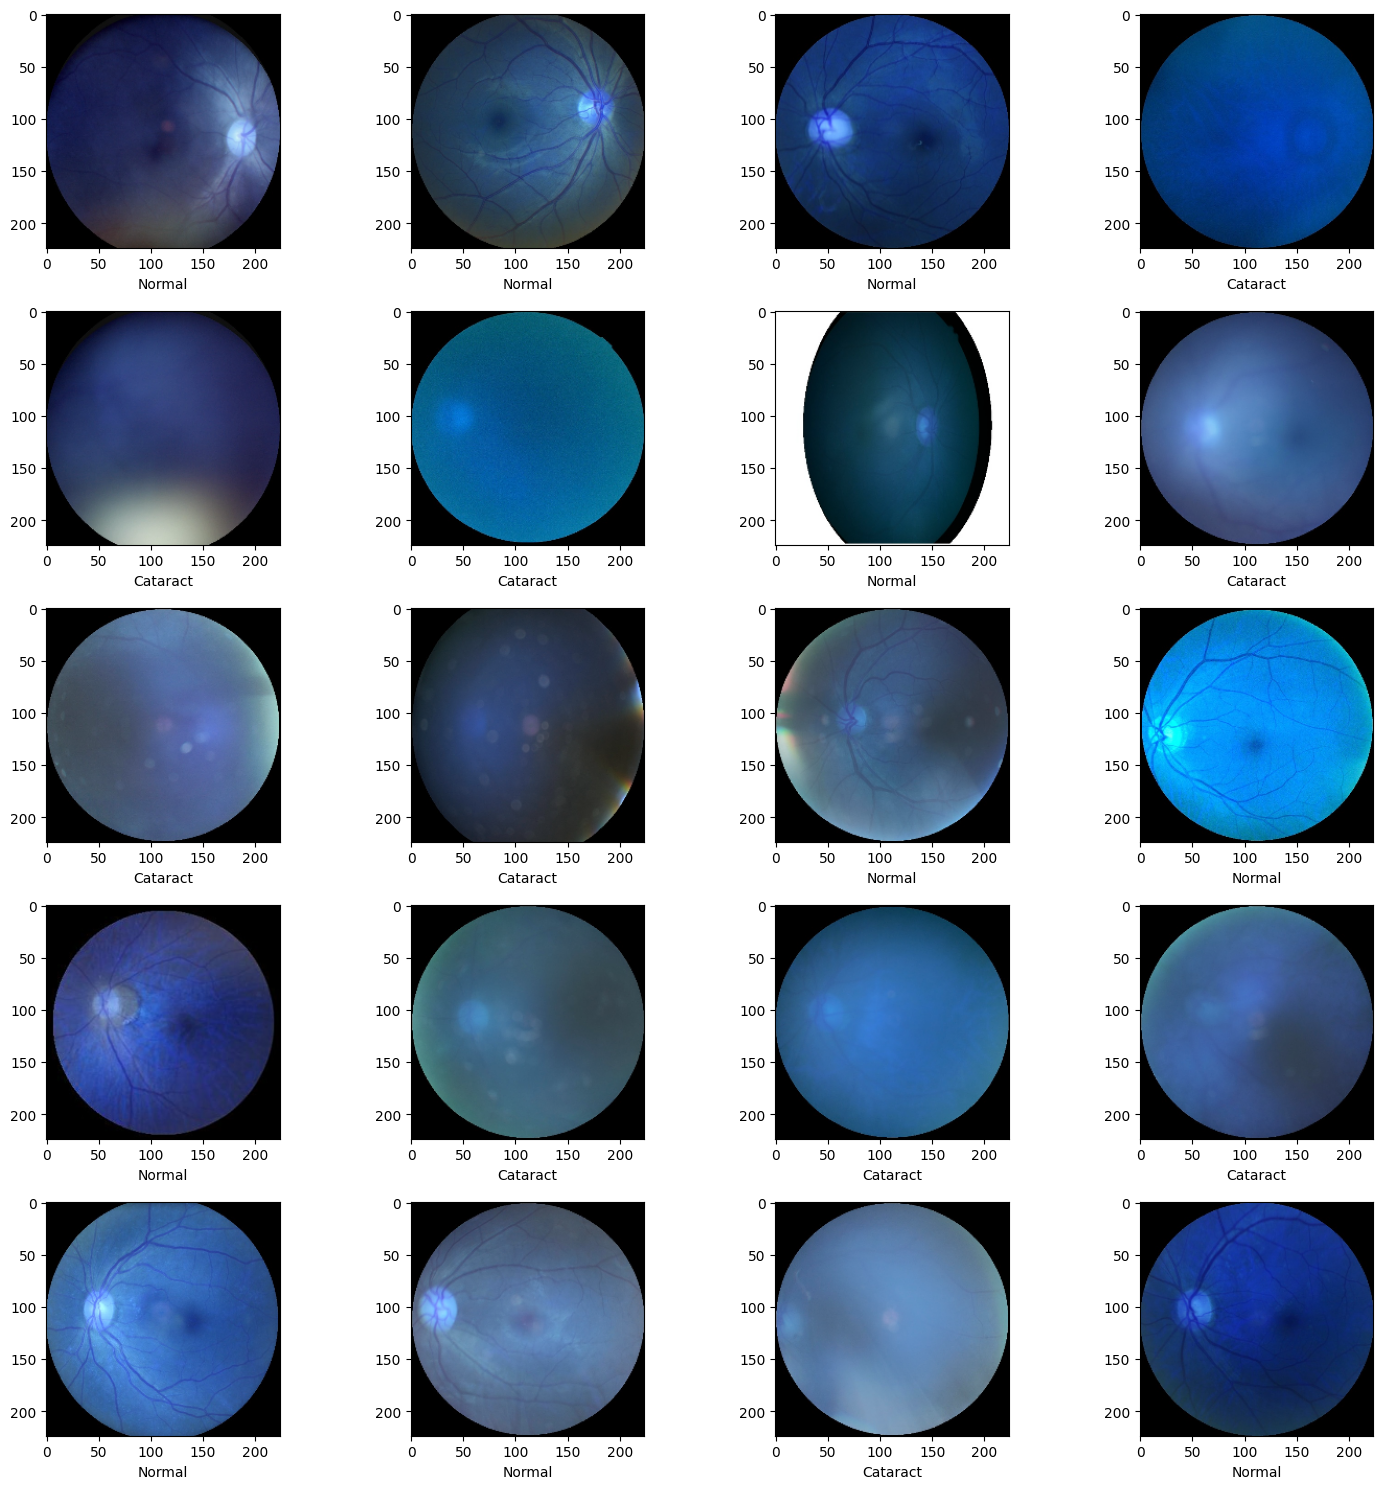

In [25]:
plt.figure(figsize = (15,15))

for i in range(20):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category == 1:
        label = 'Cataract'
        
    else:
        label = 'Normal'
        
    plt.subplot(5, 4, i+1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()

In [27]:
###################### Create Input & Output set for testing & training model ######################

x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

In [28]:
x.shape

(1188, 224, 224, 3)

In [29]:
y.shape

(1188,)

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 100)

In [31]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = (image_size,image_size,3))

80134624/80134624 [==============================] - 6s 0us/step


In [32]:
for layer in vgg.layers:
    layer.trainable = False

In [33]:
############## Use Sequential model to train ##############

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense


In [34]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [41]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])


In [42]:
############## Create a trained model in "Model.h5" file ##############

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint('CNN_Trained_Model.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True,
                             save_weights_only = False, save_freq = 'epoch')

earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1)

In [43]:
############## Fit the model to train and check loss & accuracy ##############

history = model.fit(x_train, y_train, batch_size = 32, epochs = 15, validation_data = (x_test,y_test), 
                    verbose = 1, callbacks = [checkpoint, earlystop])

Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 2.1070 - accuracy: 0.8811
Epoch 1: val_accuracy improved from -inf to 0.92857, saving model to CNN_Trained_Model.h5
30/30 [==============================] - 131s 4s/step - loss: 2.1070 - accuracy: 0.8811 - val_loss: 0.8360 - val_accuracy: 0.9286
Epoch 2/15
30/30 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.9611
Epoch 2: val_accuracy improved from 0.92857 to 0.94538, saving model to CNN_Trained_Model.h5
30/30 [==============================] - 156s 5s/step - loss: 0.5055 - accuracy: 0.9611 - val_loss: 0.5795 - val_accuracy: 0.9454
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9789
Epoch 3: val_accuracy improved from 0.94538 to 0.95378, saving model to CNN_Trained_Model.h5
30/30 [==============================] - 144s 5s/step - loss: 0.1337 - accuracy: 0.9789 - val_loss: 0.4203 - val_accuracy: 0.9538
Epoch 4/15
30/30 [==============================] - 

In [44]:
loss, accuracy = model.evaluate(x_test, y_test)


8/8 [==============================] - 29s 4s/step - loss: 0.2854 - accuracy: 0.9664


In [45]:
print('Loss : {:.2f}%'.format(loss * 100))
print('Accuracy : {:.2f}%'.format(accuracy * 100))


Loss : 28.54%
Accuracy : 96.64%


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = model.predict(x_test)


8/8 [==============================] - 29s 4s/step


In [47]:
############## As the "y_pred" is continuous use threshold = 0.5 ##############

threshold = 0.5

y_pred_binary = y_pred > threshold

In [48]:
acc_sc = accuracy_score(y_test, y_pred_binary)
print('Accuracy Score :{:.2f}%'.format(acc_sc * 100))

Accuracy Score :96.64%


In [49]:
print(classification_report(y_test, y_pred_binary))


              precision    recall  f1-score   support

           0       0.98      0.95      0.97       117
           1       0.95      0.98      0.97       121

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.97      0.97      0.97       238



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

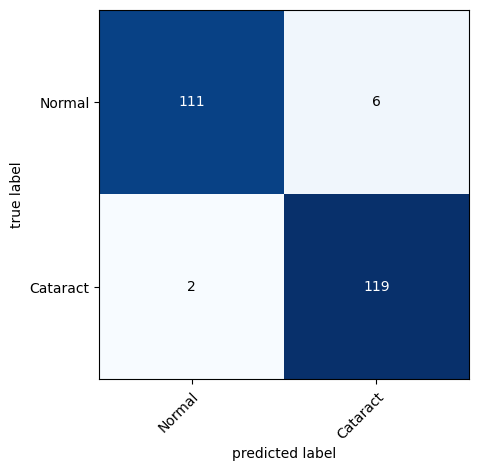

In [51]:
############## Plot Confusion Matrix ##############

from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)
plot_confusion_matrix(conf_mat = cm, class_names = ["Normal","Cataract"])

## Actucal Output

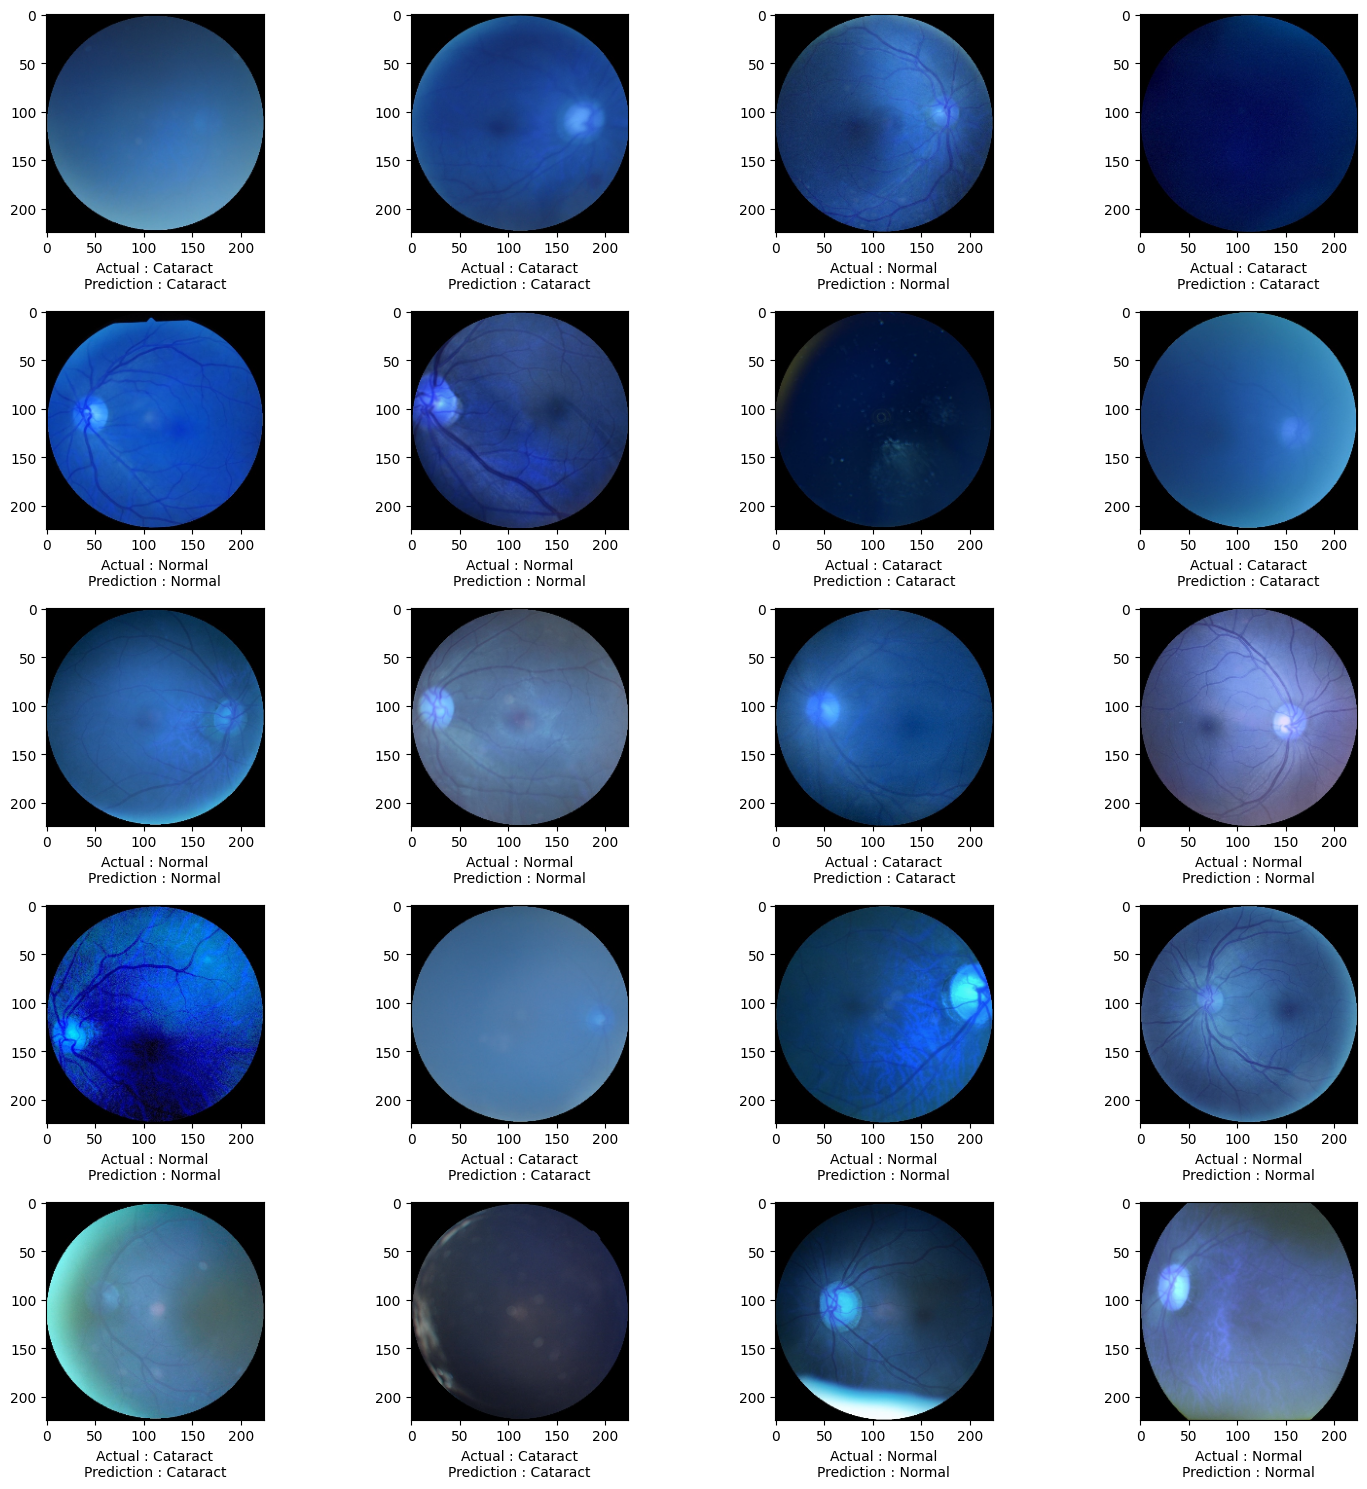

In [52]:
plt.figure(figsize = (15,15))

for i in range(20):
    
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred_binary[sample]
    
    if category == 1:
        label = 'Cataract'
    else:
        label = 'Normal'
        
    if pred_category == 1:
        pred_label = 'Cataract'
    else:
        pred_label = 'Normal'
        
    plt.subplot(5, 4, i+1)
    plt.imshow(image)
    
    plt.xlabel('Actual : {}\nPrediction : {}'.format(label, pred_label))
    
plt.tight_layout() 

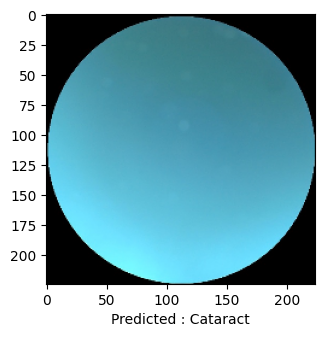

In [67]:
    plt.figure(figsize = (15,15))

    
    sample = 236
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred_binary[sample]
    
    if category == 1:
        label = 'Cataract'
    else:
        label = 'Normal'
        
    if pred_category == 1:
        pred_label = 'Cataract'
    else:
        pred_label = 'Normal'
        
    plt.subplot(5, 4, i+1)
    plt.imshow(image)
    
    plt.xlabel('Predicted : {}'.format(pred_label))
    
    plt.tight_layout() 